In [149]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F
import torchvision.models as models

from sklearn.model_selection import train_test_split

from pytorch_lightning import loggers as pl_loggers

### Tensorboard

In [2]:
%load_ext tensorboard

### Define Transforms

In [125]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225])

In [118]:
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

validation_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

### Create train, validation, test sets

In [ ]:
benign_path = "features/images/benign/gaf/branch_instructions"
ransomware_path = "features/images/ransomware/gaf/branch_instructions"

In [42]:
benign_paths = list()
ransomware_paths = list()
classes = list()

for path in glob.glob(os.path.join(benign_path, "*")):
    classes.append(path.split("/")[2])
    benign_paths.append(path)

for path in glob.glob(os.path.join(ransomware_path, "*")):
    classes.append(path.split("/")[2])
    ransomware_paths.append(path)

random.shuffle(benign_paths)
random.shuffle(ransomware_paths)

test_benign_image_paths, train_valid_benign_image_paths = benign_paths[:10], benign_paths[10:]
test_ransomware_image_paths, train_valid_ransomware_image_paths = ransomware_paths[:10], ransomware_paths[10:]

test_image_paths = test_benign_image_paths + test_ransomware_image_paths
train_valid_image_paths = train_valid_benign_image_paths + train_valid_ransomware_image_paths

classes = list(set(classes))

print(f"Test dataset len: {len(test_image_paths)}")
print(f"Train validation dataset len: {len(train_valid_image_paths)}")
print(f"Path example: {train_valid_image_paths[0]}")
print(f"Class example: {classes[0]}")

Test dataset len: 20
Train validation dataset len: 436
Path example: features/images/benign/gaf/branch_instructions/benign_31.jpg
Class example: ransomware


In [7]:
benign_path = "features/images/benign/gaf/branch_instructions"
ransomware_path = "features/images/ransomware/gaf/branch_instructions"

train_valid_image_paths = list()
classes = list()

for path in glob.glob(os.path.join(benign_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

for path in glob.glob(os.path.join(ransomware_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

classes = list(set(classes))
random.shuffle(train_valid_image_paths)

print(f"Path example: {train_valid_image_paths[0]}")
print(f"Class example: {classes[0]}")

Path example: features/images/ransomware/gaf/branch_instructions/ransomware_36.jpg
Class example: ransomware


In [43]:
train_image_paths, valid_image_paths = train_test_split(train_valid_image_paths, train_size=0.7, shuffle=True)

print(f"Train size: {len(train_image_paths)}")
print(f"Valid size {len(valid_image_paths)}")

Train size: 305
Valid size 131


In [44]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

idx_to_class

{0: 'ransomware', 1: 'benign'}

### Dataset class

In [45]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create datasets

In [119]:
train_dataset = RansomwareDetectionDataset(train_image_paths, transform=train_transformations)
validation_dataset = RansomwareDetectionDataset(valid_image_paths, transform=validation_transformations)
test_dataset = RansomwareDetectionDataset(test_image_paths, transform=test_transformation)

print(f"Tensor shape of the image: {train_dataset[1][0].shape}")
print(f"Label of the image: {idx_to_class[train_dataset[1][1]]}")

Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: ransomware


### Create Dataloaders

In [280]:
def create_dataloaders(batch_size=4):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

In [281]:
train_loader, validation_loader = create_dataloaders()

Train dataloader shape torch.Size([4, 3, 50, 50])
Validation dataloader shape torch.Size([4, 3, 50, 50])


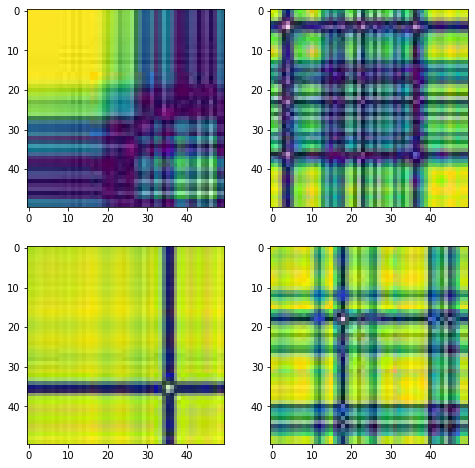

In [227]:
rows = 2
columns = 2
fig = plt.figure(figsize=(8, 8))

train_iter = iter(train_loader)
valid_iter = iter(validation_loader)

for index in range(0, 4):
    train_image, train_label = next(train_iter)
    valid_image, valid_label = next(valid_iter)
    ax = fig.add_subplot(rows, columns, index + 1)

    x_train = train_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
    plt.imshow(x_train.numpy().transpose(1, 2, 0))

    x_valid = valid_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
    plt.imshow(x_valid.numpy().transpose(1, 2, 0))


### Create baseline Model

In [275]:
class BaselineNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(in_features=12 * self.final_size * self.final_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00001)
    


In [276]:
baseline_model = BaselineNetwork(number_of_classes=len(classes), image_size=50)

In [277]:
logger = pl_loggers.TensorBoardLogger("logs/", name="Baseline")
trainer = pl.Trainer(max_epochs=15, log_every_n_steps=1, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [278]:
trainer.fit(baseline_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 14: 100%|██████████| 110/110 [00:04<00:00, 25.02it/s, loss=0.483, v_num=6, Loss/valid=0.526, Accuracy/valid=0.740, Loss/train=0.494, Accuracy/train=0.769]


In [279]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6010 (pid 97026), started 1 day, 7:50:09 ago. (Use '!kill 97026' to kill it.)

### Verify the model

In [282]:
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=0)

Epoch 0: 100%|██████████| 436/436 [1:02:49<00:00,  8.64s/it, loss=0.691, v_num=2, Loss/validation=0.643]


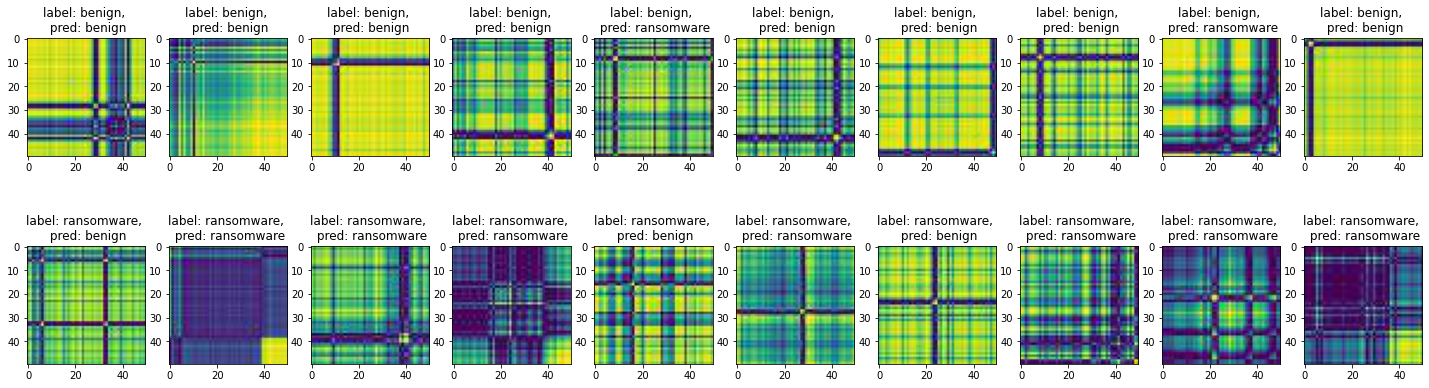

In [283]:
fig = plt.figure(figsize=(25, 7))
spec = fig.add_gridspec(ncols=10, nrows=2)

test_iter = iter(test_dataloader)

count = 0
for row in range(2):
    for col in range(10):
        batch, label = next(test_iter)
        pred = baseline_model(batch)
        pred = pred.argmax(dim=1)

        ax = fig.add_subplot(spec[row, col])

        x = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        ax.imshow(x.numpy().transpose(1, 2, 0))
        ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

        count += 1

### Create CNN based on resnet

In [128]:
class ResnetNetwork(pl.LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Linear(512, 2, bias=True)

        for parameter in base_model.parameters():
            parameter.requires_grad = True
        for parameter in base_model.fc.parameters():
            parameter.requires_grad = True

        self.model = base_model
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        self.log("loss/train", loss, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalars("loss", {"train_loss": loss}, global_step=self.current_epoch)
        
        self.log("accuracy/train", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalars("accuracy", {"train_accuracy": accuracy}, global_step=self.current_epoch)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        self.log("loss/val", loss, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalars("loss", {"val_loss": loss}, global_step=self.current_epoch)

        self.log("accuracy/val", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalars("accuracy", {"val_accuracy": accuracy}, global_step=self.current_epoch)

        return accuracy

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [135]:
resnet_model = ResnetNetwork()

In [139]:
resnet_trainer = pl.Trainer(max_epochs=15, log_every_n_steps=1, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [140]:
resnet_trainer.fit(resnet_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)


  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 80/80 [00:17<00:00,  4.46it/s, loss=0.471, v_num=1, loss/val=0.823, accuracy/val=0.742, loss/train=0.397, accuracy/train=0.843]


In [141]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6009 (pid 77691), started 0:19:36 ago. (Use '!kill 77691' to kill it.)